# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [39]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "./traffic-signs-data/train.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [40]:
### Replace each question mark with the appropriate value.

import numpy as np

# TODO: Number of training examples
n_train = len(y_train)

# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [41]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

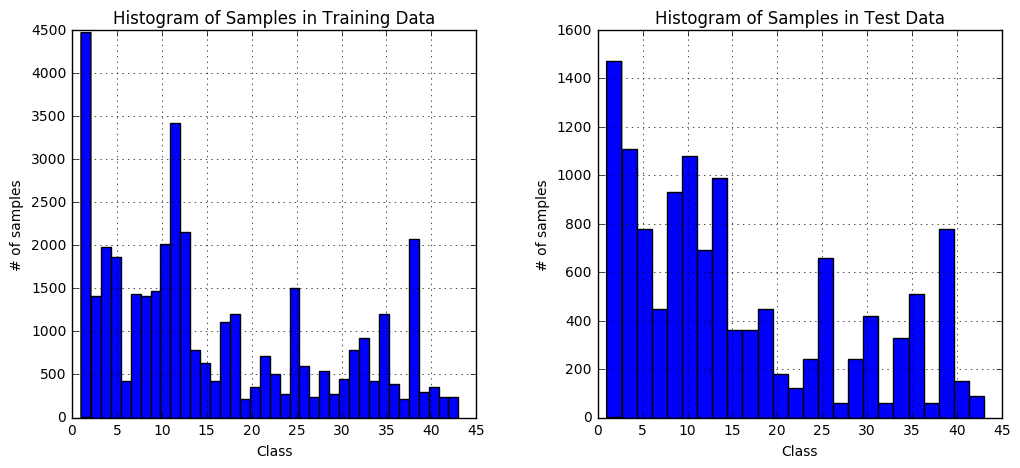

In [42]:
def displayHistogram(y1, y2):
    # histogram of label frequency in the training data
    f, (ax1, ax2) = plt.subplots(1, 2)

    # Fine-tune figure; make subplots spaced out
    f.subplots_adjust(wspace = .3)
    f.set_size_inches(12, 5)

    ax1.hist(y1, bins = "auto", range = (1, 43))
    ax1.set_xlabel('Class')
    ax1.set_ylabel('# of samples')
    ax1.set_title('Histogram of Samples in Training Data')
    ax1.grid(True)

    ax2.hist(y2, bins = "auto", range = (1, 43))
    ax2.set_xlabel('Class')
    ax2.set_ylabel('# of samples')
    ax2.set_title('Histogram of Samples in Test Data')

    ax2.grid(True)

    plt.show()   
    
displayHistogram(y_train, y_test)

Code below will parititon out the classes that are imbalanced currenrly. This way I can modify the images in those classes alone and not bother the classes that are well represented 

In [43]:
# examples of each unique class
transform = []
classes = []

for n in range(n_classes):
    #group by class and get the first example in each group
    group = X_train[y_train == n]
    
    transform.append(group)
    classes.append(n)

print(len(transform))
print(len(classes))

43
43


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

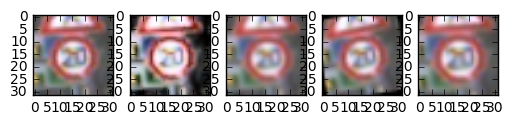

In [44]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# creating modified versions of each class in order to tackle the problem of imbalance
# will double the amount of samples present for each class

# going to use opencv to modify the images
import cv2

def normalize(img):
    #enhancing the contrast
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    # equalize the histogram of the Y channel
    yuv[:,:,0] = cv2.equalizeHist(yuv[:,:,0])
    # convert the YUV image back to RGB format
    rgb = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)

    # image normalization
    #(32 x 32 x 3)
    return cv2.normalize(rgb, np.zeros((32, 32, 3)), 0, 255, cv2.NORM_MINMAX)
    # plt.imshow(normalized)
    # plt.show()

def noisy(img):
    # randomly perturbed images
    kernel = np.ones((2,2),np.float32)/4
    return cv2.filter2D(img,-1,kernel)
    # plt.imshow(noisy)
    # plt.show()

def rotate(img):
    #rotations of image in range -15 to 15
    deg = np.random.uniform(-15, 15, size=1)
    rows = cols = img.shape[0]
    rot = cv2.getRotationMatrix2D((cols/2,rows/2), deg, 1)
    return cv2.warpAffine(img,rot,(cols,rows))
    # plt.imshow(rot)
    # plt.show()

def scale(img):
    #scale image [.9,1.1] ratio
    deg = np.random.uniform(0.9, 1.1, size=1)
    # resize = cv2.resize(img, (32,32), dst=np.zeros((32, 32, 3)), fx = deg, fy = deg)
    size = 32 * deg
    start1 = np.random.uniform(0, 32-size, size=1)
    start2 = np.random.uniform(0, 32-size, size=1)
    pts1 = np.float32([[start1, start2], [start1+size, start2], [start1, start2+size], [start1+size, start2+size]])
    pts2 = np.float32([[0, 0], [32, 0], [0, 32], [32, 32]])
    M = cv2.getPerspectiveTransform(pts1, pts2)
    return cv2.warpPerspective(img, M, (32,32))
    # print(resize.shape)
    # plt.imshow(resize)
    # plt.show()
    # print(img == resize
    
def display(img):
    # displaying the original and the 4 new transformations
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
    ax1.imshow(img)
    ax2.imshow(normalize(img))
    ax3.imshow(noisy(img))
    ax4.imshow(rotate(img))
    ax5.imshow(scale(img))

# gonna display an example of how I'm transforming the data set
display(X_train[0])

Code below transofrms each image of a class that is imbalanced 

41996  new samples in modified_Xtrain of shape (41996, 32, 32, 3)
41996  new samples in modified_ytrain of shape (41996,)


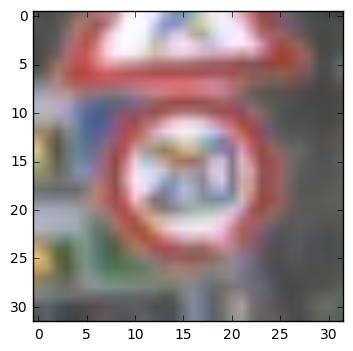

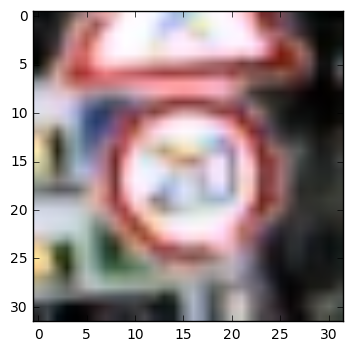

In [45]:
#these lists will hold the modified images
modified_Xtrain = []
modified_ytrain = []

for group, class_num in zip(transform, classes):
    if(len(group) < 800):
        # print(class_num)
        for img in group:
            modified_Xtrain.append(normalize(img))
            modified_Xtrain.append(noisy(img))
            modified_Xtrain.append(rotate(img))
            modified_Xtrain.append(scale(img))

            modified_ytrain.append(class_num)
            modified_ytrain.append(class_num)
            modified_ytrain.append(class_num)
            modified_ytrain.append(class_num)

modified_Xtrain = np.array(modified_Xtrain)
modified_ytrain = np.array(modified_ytrain)
print(len(modified_Xtrain), " new samples in modified_Xtrain of shape", modified_Xtrain.shape)
print(len(modified_ytrain), " new samples in modified_ytrain of shape", modified_ytrain.shape)

# print(modified_ytrain[0])
plt.imshow(X_train[y_train == modified_ytrain[0]][0])
plt.show()
plt.imshow(modified_Xtrain[0])
plt.show()

The code below will combine the new modified set of images to the original training set

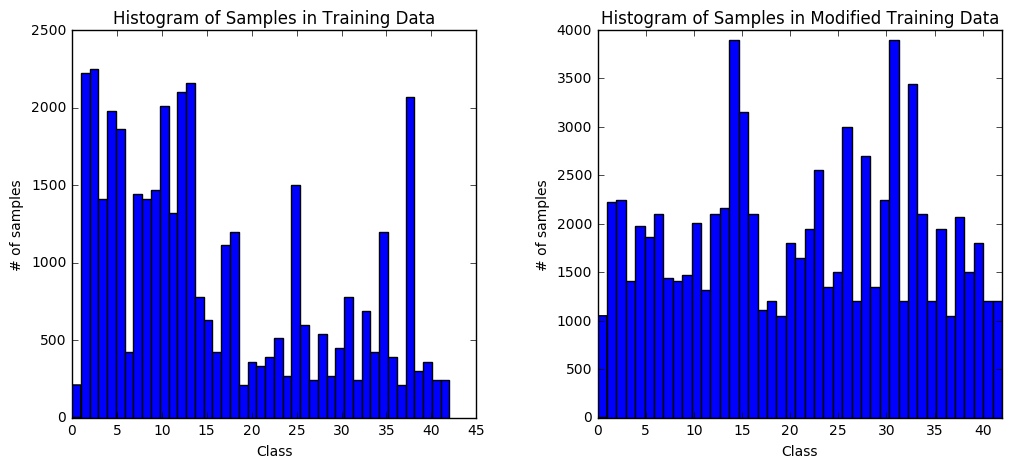


The new Input Dataset has 81205 samples in it, which has a shape of (81205, 32, 32, 3)
The new Label Dataset has 81205 samples in it, which has a shape of (81205,)


In [46]:
# print(type(y_train))
# print(type(modified_ytrain))


new_ytrain = np.append(y_train, modified_ytrain)
new_Xtrain = np.concatenate((X_train, modified_Xtrain), axis=0)

# print(np.bincount(y_train))
# print(np.bincount(modified_ytrain))
# print(np.bincount(new_ytrain))

# print(len(np.unique(new_train)))
# print(y_train.shape)
# print(modified_ytrain.shape)
# print(new_train.shape)
# displayHistogram(y_train, new_train)

f, (ax1, ax2) = plt.subplots(1, 2)

# Fine-tune figure; make subplots spaced out
f.subplots_adjust(wspace = .3)
f.set_size_inches(12, 5)

ax1.hist(y_train, bins=43)
ax1.set_xlabel('Class')
ax1.set_ylabel('# of samples')
ax1.set_title('Histogram of Samples in Training Data')
    
ax2.hist(new_ytrain, bins=43)
ax2.set_xlabel('Class')
ax2.set_ylabel('# of samples')
ax2.set_title('Histogram of Samples in Modified Training Data')
plt.xlim([0,42])
plt.show()

print()

print("The new Input Dataset has", len(new_Xtrain), "samples in it, which has a shape of", new_Xtrain.shape)
print("The new Label Dataset has", len(new_ytrain), "samples in it, which has a shape of", new_ytrain.shape)

In [47]:
y_train = new_ytrain
X_train = new_Xtrain

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

First I put together a histogram of the examples by class. It seems that there were a lot of under represented classes, while other classes had over 1000 examples.
So, I decided to transform the images of any class with less than 800 samples.

Applied Transformations:

1. Convert to YUV space. Normalize the Y Channel. Convert back to RGB and normalize entire image.
2. Add random distortions using a 2x2 filter to the image.
3. Rotate images using a random value in the range of [-15, 15] degrees.
4. Scale images using a random value in the range of [0.9, 1.1].

I got the idea for these transformations from the "Traffic Sign Recognition with Multi-Scale Convolutional Networks" by Pierre Sermanet and Yann LeCun. 

This game me atleast 1000  examples per class to train my model on.

In [48]:
# going to shuffle the dataset
from sklearn.utils import shuffle

The code below was used to take a small sample of each class to train the CNN on.
Will comment this code out when training pipeline on the entire model

In [49]:
# print(len(X_train))
# print(len(y_train))

X_train, y_train = shuffle(X_train, y_train)

"""
newX_train = []
newy_train = []
for n in range(n_classes):
    #group by class and get the first 3 examples in each group
    group = X_train[y_train == n][:20]
    
    # print(group.shape)
    
    for img in group:
        # print(img.shape)
        newX_train.append(img)
        newy_train.append(n)
# print(len(newX_train))
# print(new_Xtrain[0].shape)

print(newX_train[0].shape)
print(len(newX_train))
print(np.bincount(newy_train))
"""

'\nnewX_train = []\nnewy_train = []\nfor n in range(n_classes):\n    #group by class and get the first 3 examples in each group\n    group = X_train[y_train == n][:20]\n    \n    # print(group.shape)\n    \n    for img in group:\n        # print(img.shape)\n        newX_train.append(img)\n        newy_train.append(n)\n# print(len(newX_train))\n# print(new_Xtrain[0].shape)\n\nprint(newX_train[0].shape)\nprint(len(newX_train))\nprint(np.bincount(newy_train))\n'

In [50]:
"""
X_train = newX_train
y_train = newy_train

print(X_train[0].shape)
print(len(X_train))
print(np.bincount(y_train))
"""

'\nX_train = newX_train\ny_train = newy_train\n\nprint(X_train[0].shape)\nprint(len(X_train))\nprint(np.bincount(y_train))\n'

In [51]:
# the above code has already shuffled everything
# the following code will also shulle everything as it partitions everyting into the CV and Training Sets
from sklearn.model_selection import train_test_split

X_train, X_CV, y_train, y_CV = train_test_split(X_train, y_train, test_size=0.33, random_state=217)

print(len(X_train))
print(len(y_train))

print(len(X_CV))
print(len(y_CV))

# print(X_train.shape)
# print(y_train.shape)

54407
54407
26798
26798


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

Generating Additional Data:
There was a huge imbalance with in the training set. There were a large number of examples for some classes and very few for other. So, as I stated in question 1, I decided to transform any class with less than 800 examples. 
I went through each image in an imbalanced class, and applied 4 different transformations to those images. This resulted in each class having atleast 1000 examples to train the classifier. In total, my training set jumped up from 39209 examples in total to 81205 examples before being split into a Cross Validation(CV) and Training set. 

Setting up DataSets:
I used **sklearn.util's** shuffle method to shuffle the new, larger dataset. After shuffling, I used **sklearn.model_selection's** train_test_split method to split the new training set into a CV and a Training Set. One third of the dataset is being used for Cross Validation, while the other two-thirds are used for training.

In [52]:
import tensorflow as tf

In [53]:
from tensorflow.contrib.layers import flatten

In [54]:
def CNN(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 12), mean = mu, stddev = sigma))
    conv1_b  = tf.Variable(tf.zeros(12))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # normalization
    conv1 = tf.nn.local_response_normalization(conv1)
    
    # Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 12, 32), mean = mu, stddev = sigma))
    conv2_b  = tf.Variable(tf.zeros(32))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # normalization
    conv2 = tf.nn.local_response_normalization(conv2)
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    dim = fc0.get_shape()[1].value
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(dim, 192), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(192))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # dropout
    fc1 = tf.nn.dropout(fc1, keep_prob = 0.5)
    
    # SOLUTION: Activation.
    # fc1 = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(192, 84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2 = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [55]:
def CNN2(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3 Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 12), mean = mu, stddev = sigma))
    # conv1_b  = tf.Variable(tf.zeros(6))
    # conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1_b = tf.Variable(tf.truncated_normal(shape=[12], mean = mu, stddev = sigma))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID')
    conv1 = tf.nn.bias_add(conv1, conv1_b) 
    
    # normalization
    conv1 = tf.nn.local_response_normalization(conv1)
    
    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 12, 32), mean = mu, stddev = sigma))
    # conv2_b  = tf.Variable(tf.zeros(16))
    # conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2_b = tf.Variable(tf.truncated_normal(shape=[32], mean = mu, stddev = sigma))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID')
    conv2 = tf.nn.bias_add(conv2, conv2_b) 
    
    # normalization
    conv2 = tf.nn.local_response_normalization(conv2)
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    dim = fc0.get_shape()[1].value
    # print(dim)
    
    # Layer 3: Fully Connected. Input = 400. Output = 192.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(dim, 192), mean = mu, stddev = sigma))
    # fc1_b = tf.Variable(tf.zeros(192))
    # fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1_b = tf.Variable(tf.truncated_normal(shape=[192], mean = mu, stddev = sigma))
    fc1   = tf.matmul(fc0, fc1_W)
    fc1 = tf.nn.bias_add(fc1, fc1_b) 
    
    # dropout
    fc1 = tf.nn.dropout(fc1, keep_prob = 0.5)
    
    # Activation.
    # fc1 = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 192. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(192, 84), mean = mu, stddev = sigma))
    # fc2_b  = tf.Variable(tf.zeros(84))
    # fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2_b = tf.Variable(tf.truncated_normal(shape=[84], mean = mu, stddev = sigma))
    fc2 = tf.matmul(fc1, fc2_W)
    fc2 = tf.nn.bias_add(fc2, fc2_b) 
    
    # Activation.
    fc2 = tf.nn.relu(fc2)
    
    # dropout
    # fc2 = tf.nn.dropout(fc2, keep_prob = 0.5)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    # fc3_b  = tf.Variable(tf.zeros(n_classes))
    # logits = tf.matmul(fc2, fc3_W) + fc3_b
    fc3_b = tf.Variable(tf.truncated_normal(shape=[n_classes], mean = mu, stddev = sigma))
    logits = tf.matmul(fc2, fc3_W)
    logits = tf.nn.bias_add(logits, fc3_b) 
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I started out by implementing the same architecture as the LeNet Lab, but I changed the size of the first filter to account for RGB channels. From there, I played around 

1. 5x5x3 convolution (32x32x3 in, 28x28x6 out)
2. Normalization
3. ReLU
4. 2x2 max pool (28x28x6 in, 14x14x6 out)
5. 5x5x16 convolution (14x14x6 in, 10x10x16 out)
6. Normalization
7. ReLU
8. 2x2 max pool (10x10x16 in, 5x5x16 out)
9. Flatten (1x1x400 -> 400)
10. Fully connected layer (400 in, 192 out)
11. Dropout layer
12. Fully connected layer (192 in, 84 out)
13. RELU
14. Fully connected layer (84 in, 43 out)

In [56]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

In [57]:
rate = 0.0007

BATCH_SIZE = 128
EPOCHS = 20

logits = CNN2(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [58]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [21]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_CV, y_CV)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.10f}".format(validation_accuracy))
        print()
    
    
    saver.save(sess, './model/model.ckpt')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.9095454884

EPOCH 2 ...
Validation Accuracy = 0.9563027092

EPOCH 3 ...
Validation Accuracy = 0.9732442719

EPOCH 4 ...
Validation Accuracy = 0.9774610045

EPOCH 5 ...
Validation Accuracy = 0.9789163370

EPOCH 6 ...
Validation Accuracy = 0.9836554967

EPOCH 7 ...
Validation Accuracy = 0.9843271885

EPOCH 8 ...
Validation Accuracy = 0.9879841778

EPOCH 9 ...
Validation Accuracy = 0.9863422643

EPOCH 10 ...
Validation Accuracy = 0.9891036645

EPOCH 11 ...
Validation Accuracy = 0.9890663481

EPOCH 12 ...
Validation Accuracy = 0.9894395103

EPOCH 13 ...
Validation Accuracy = 0.9847376669

EPOCH 14 ...
Validation Accuracy = 0.9901485185

EPOCH 15 ...
Validation Accuracy = 0.9907828942

EPOCH 16 ...
Validation Accuracy = 0.9918650645

EPOCH 17 ...
Validation Accuracy = 0.9916411672

EPOCH 18 ...
Validation Accuracy = 0.9921262780

EPOCH 19 ...
Validation Accuracy = 0.9898499887

EPOCH 20 ...
Validation Accuracy = 0.9910441077

Model saved


#### 7:37 pm 1/24/17 CNN2
EPOCH 80 ...
Validation Accuracy = 0.2535211280

#### 7:39 pm 1/24/17 CNN
EPOCH 80 ...
Validation Accuracy = 0.2253521131

#### 7:43 pm 1/24/17 CNN2 after adding normalization 
EPOCH 80 ...
Validation Accuracy = 0.5211267631

#### 7:43 pm 1/24/17 CNN2 after adding normalization before pooling
EPOCH 80 ...
Validation Accuracy = 0.5985915510

#### 8:10 pm 1/24/17 CNN2 using relu and dropout in conjunction
EPOCH 80 ...
Validation Accuracy = 0.3873239445

#### 8:11 pm 1/24/17 CNN2 using relu and dropout in conjunction
EPOCH 80 ...
Validation Accuracy = 0.2394366203

#### 8:12 pm 1/24/17 CNN2 using only dropout
EPOCH 80 ...
Validation Accuracy = 0.4225352115

#### 8:26 pm 1/24/17 CNN2 dropout and then relu
EPOCH 80 ...
Validation Accuracy = 0.5492957738

#### 8:26 pm 1/24/17 CNN2 dropout =0.75
EPOCH 100 ...
Validation Accuracy = 0.4647887324

#### 8:54 pm 1/24/17 CNN2 dropout =0.5
EPOCH 90 ...
Validation Accuracy = 0.4788732399

#### 8:56 pm 1/24/17 CNN2
EPOCH 200 ...
Validation Accuracy = 0.5000000025

#### 9:37 pm 1/24/17 CNN2 relu and then dropout
EPOCH 80 ...
Validation Accuracy = 0.4154929603

#### 9:40 pm 1/24/17 CNN2 relu only
EPOCH 80 ...
Validation Accuracy = 0.5492957772

#### 9:40 pm 1/24/17 CNN2 learning rate = 0.01
EPOCH 80 ...
Validation Accuracy = 0.3521126761

#### 9:40 pm 1/24/17 CNN2 learning rate = 0.005 and dropout and then relu
EPOCH 80 ...
Validation Accuracy = 0.5140845096

#### 11:15 pm 1/24/17 CNN2 dropout and then relu
EPOCH 80 ...
Validation Accuracy = 0.5352112676

#### 11:18 pm 1/24/17 CNN2 dropout + relu and then relu
EPOCH 80 ...
Validation Accuracy = 0.4014084507

#### 11:24 pm 1/24/17 CNN with similar architecture
EPOCH 80 ...
Validation Accuracy = 0.5985915518

## doubled the size of the sample set

#### 11:24 pm 1/24/17 CNN 
EPOCH 80 ...
Validation Accuracy = 0.7394366197

#### 11:24 pm 1/24/17 CNN2 
EPOCH 80 ...
Validation Accuracy = 0.7535211251

## launched on AWS

#### 2:10 am 1/25/17 CNN2
EPOCH 80 ...
Validation Accuracy = 0.9918650646
EPOCH 100 ...
Validation Accuracy = 0.9907828942

#### 2:15 am 1/25/17
EPOCH 20 ...
Validation Accuracy = 0.9825360102

#### 2:23 am 1/25/17
EPOCH 40 ...
Validation Accuracy = 0.9889917158

#### 2:30 am 1/25/17
EPOCH 50 ...
Validation Accuracy = 0.9909694752

#### 2:39 am 1/25/17
EPOCH 60 ...
Validation Accuracy = 0.9904470483

#### 2:47 am 1/25/17
EPOCH 55 ...
Validation Accuracy = 0.9895141428

#### 2:58 am 1/25/17
EPOCH 70 ...
Validation Accuracy = 0.9902231510

#### 8:56 am 1/28/17 learning rate = 0.0005
EPOCH 20 ...
Validation Accuracy = 0.9914919023

#### 9:01 am 1/28/17 learning rate = 0.0009
EPOCH 20 ...
Validation Accuracy = 0.9910441077

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I used the Adam optimizer that was also used in the LeNet lab.

Hyperparameters:

    batch size: 128
    epochs: 10
    learning rate: 0.001
    mu: 0
    sigma: 0.1
    keep probability: 0.5


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

A lot of my work was trial and error. I did do some research on the side and got some ideas from CIFAR-10 demo from Stanford, and TensorFlow. I based my model partially on the example given by [Tensorflow](https://www.tensorflow.org/tutorials/deep_cnn/#cifar-10_model). Before I modelled my network on this example, I was getting accuracy in the single digits. I had a really hard time figuring out why; I had started out by just modifying the original LENET lab. After I made the changes however, the accuracy jumped up significantly for both the validation set and the test set. From that point, I just played around with the hyper parameters until I got a result that did not fluctuate too much.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

# On AWS
#### 2:11 am 1/25/17 
Test Set Accuracy = 0.9573238319

#### 2:16 am 1/25/17
Test Set Accuracy = 0.9420427552

#### 2:23 am 1/25/17 
Test Set Accuracy = 0.9513855899

#### 2:30 am 1/25/17 
Test Set Accuracy = 0.959144893

#### 2:31 am 1/25/17
Test Set Accuracy = 0.9600158352

#### 2:39 am 1/25/17
Test Set Accuracy = 0.9592240696

#### 2:48 am 1/25/17
Test Set Accuracy = 0.9560570070

#### 2:58 am 1/25/17
Test Set Accuracy = 0.9559778304

#### 8:57 am 1/28/17
Test Set Accuracy = 0.9580364211

#### 9:01 am 1/28/17
Test Set Accuracy = 0.9561361835

In [25]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./model/model.ckpt.meta')
    saver2.restore(sess, "./model/model.ckpt")
    test_accuracy = evaluate(X_test, y_test)
    print("Test Set Accuracy = {:.10f}".format(test_accuracy))

Test Set Accuracy = 0.9566904194


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

The text on the images might make it hard to for the classifier. Since the network learns by finding patterns, any difference in text may confuse the classifier. Some of the signs that the network trained on had numbers on them which may make it hard to the network to recognize new images. The shape of the signs may also confuse the classifier. For example: a circular sign versus an octogon. 

Since I am using images that the model has never seen before, they will all be classified incorrectly. This is because the classifier has no class for these examples. So it will try to approximate to the best of its ability. 

In [65]:
import glob
import cv2
import numpy as np
import tensorflow as tf

images = []
for filename in glob.glob('./my signs/*.png'):
    img = cv2.imread(filename)
    # print(img.shape)
    # plt.imshow(img)
    # plt.show()
    images.append(img)
    
print(len(images), " ", images[0].shape)

labels = [3, 11, 1, 12, 38, 34, 18, 25]
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver3 = tf.train.import_meta_graph('./model/model.ckpt.meta')
    saver3.restore(sess, "./model/model.ckpt")
    test_accuracy = evaluate(images, labels)
    print("Test Set Accuracy = {:.10f}".format(test_accuracy))

8   (32, 32, 3)
Test Set Accuracy = 0.1250000000


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

NameError: name 'y_validation' is not defined

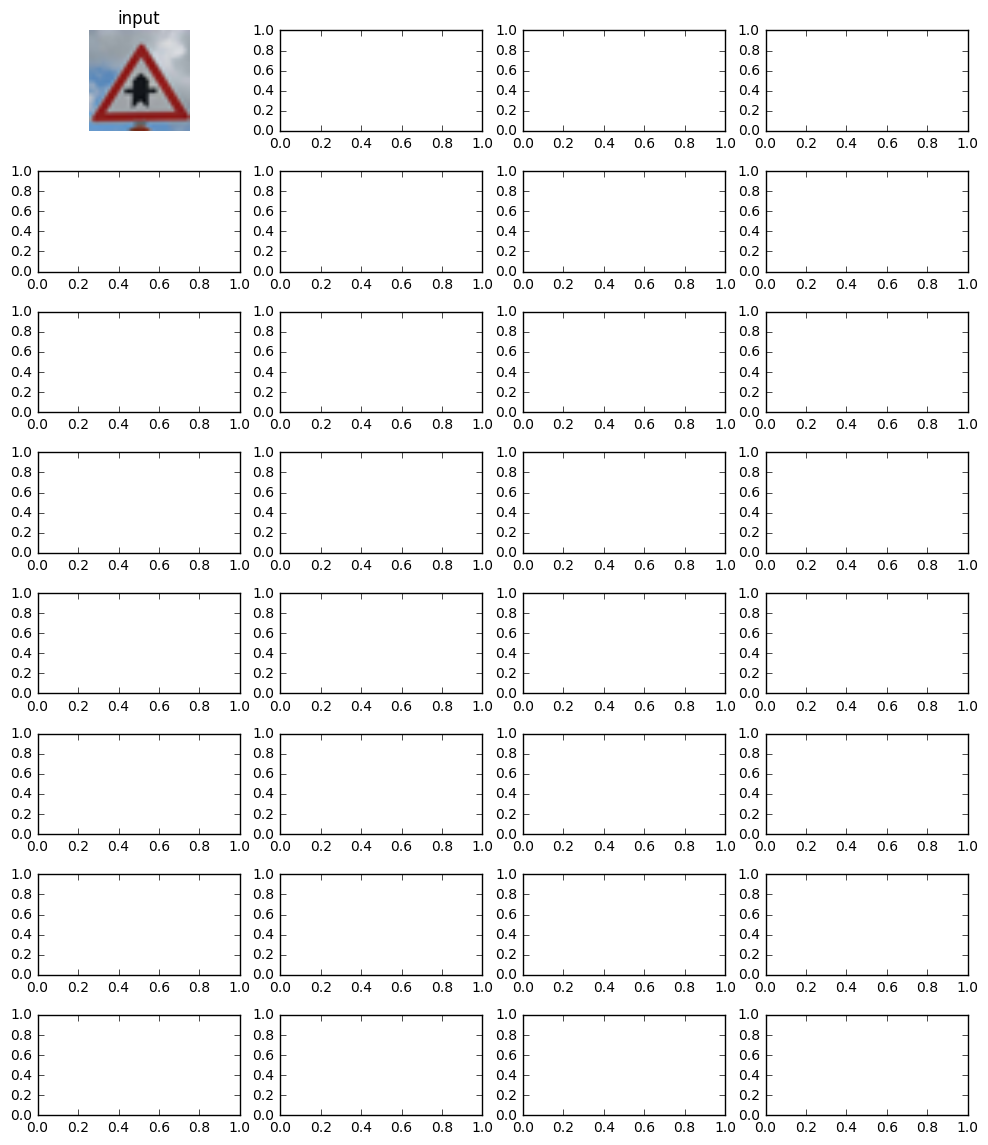

In [70]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=3)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver4 = tf.train.import_meta_graph('./model/model.ckpt.meta')
    saver4.restore(sess, "./model/model.ckpt")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: images})
    my_top_k = sess.run(top_k, feed_dict={x: images})

    
    fig, axs = plt.subplots(len(images),4, figsize=(12, 14))
    fig.subplots_adjust(hspace = .4, wspace=.2)
    axs = axs.ravel()

    for i, image in enumerate(images):
        axs[4*i].axis('off')
        axs[4*i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[4*i].set_title('input')
        guess1 = my_top_k[1][i][0]
        index1 = np.argwhere(y_validation == guess1)[0]
        axs[4*i+1].axis('off')
        axs[4*i+1].imshow(X_validation[index1].squeeze(), cmap='gray')
        axs[4*i+1].set_title('top guess: {} ({:.0f}%)'.format(guess1, 100*my_top_k[0][i][0]))
        guess2 = my_top_k[1][i][1]
        index2 = np.argwhere(y_validation == guess2)[0]
        axs[4*i+2].axis('off')
        axs[4*i+2].imshow(X_validation[index2].squeeze(), cmap='gray')
        axs[4*i+2].set_title('2nd guess: {} ({:.0f}%)'.format(guess2, 100*my_top_k[0][i][1]))
        guess3 = my_top_k[1][i][2]
        index3 = np.argwhere(y_validation == guess3)[0]
        axs[4*i+3].axis('off')
        axs[4*i+3].imshow(X_validation[index3].squeeze(), cmap='gray')
        axs[4*i+3].set_title('3rd guess: {} ({:.0f}%)'.format(guess3, 100*my_top_k[0][i][2]))

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.